In [1]:
# This cell imports everything you need
%matplotlib inline

import sys

#sys.path.insert(0, '/home/space/dominic/Viscid')


import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import viscid      # You probably don't have this yet
from viscid.plot import vpyplot as vlt
import h5py        # You probably don't have this yet
import pandas as pd
import os
import scipy.constants as constants
viscid.calculator.evaluator.enabled = True

%config InlineBackend.figure_format = 'retina'

# Put all data files (everything that ends in .xdmf or h5) into some directory and point to it
project_dir="../data_m100"



from scipy.signal import savgol_filter  #IDK what this is for


In [2]:
# This cell defines the run.  The pfd.xdmf file is all you need to point to.  It is basically an organized list of all the other data files in your data directory.
run = project_dir+"/pfd.xdmf"


# I think Kai's group is starting to move on from viscid, but off the top of my head, I don't know how to look at this stuff
#  with standard python libraries, so I still use viscid here because I'm lazy




In [3]:
# Defines a handful of useful functions

        
def interp(a, pt):
    n = ((pt - xl)/dx).astype(int)
    return a[n[0],n[1],n[2]]


def make_vec(a,b,c):
    fld = viscid.empty(a.crds,nr_comps=3)
    
    fld['x'] = a
    fld['y'] = b
    fld['z'] = c
    
    fld = fld['y=0j']
    
    return fld
        

def Get_Fields(r):
    Ex, Ey, Ez = vf['ex_ec'], vf['ey_ec'], vf['ez_ec']
    Bx, By, Bz = vf['hx_fc'], vf['hy_fc'], vf['hz_fc']
    
    
    r = np.array([r[0],0,r[2]]) # This Resets the y position to zero
    Ex = interp(Ex,r)
    Ey = interp(Ey,r)
    Ez = interp(Ez,r)
    Bx = interp(Bx,r)
    By = interp(By,r)
    Bz = interp(Bz,r)
    
    E = np.array([Ex, Ey, Ez])
    B = np.array([Bx, By, Bz])
    
    return E, B


In [4]:
# Choose the timestep of the run (The DR starts to form after t=10 in this run.  Peak Rx rate is at t=18)
t = 21

# Need to load run, activate time, before field definitions
vf = viscid.load_file(run, force_reload=True)
vf.activate_time(t)
a = vf["hx_fc"]
x,y,z = a.crds.get_crds_nc()
dx,dy,dz = a.crds.get_dx()

# E&B Fields
Ex, Ey, Ez = vf["ex_ec"], vf["ey_ec"], vf["ez_ec"] 
Bx, By, Bz = vf["hx_fc"], vf["hy_fc"], vf["hz_fc"]
E = make_vec(Ex,Ey,Ez) #These are vector variables.  E['y'] is equivalent to Ey.  Just convenient to sometimes put in a single vector variable
B = make_vec(Bx,By,Bz)

# E&B Magnitudes (also example of creating new variables with old ones)
B_mag = (Bx**2 + By**2 + Bz**2)**0.5
E_mag = (Ex**2 + Ey**2 + Ez**2)**0.5

# Parallel Electric field 
EPar = (Ex*Bx + Ey*By * Ez*Bz) / B_mag

# Current densities
jx_e, jy_e, jz_e = vf["jx_nc_e"], vf["jy_nc_e"], vf["jz_nc_e"] # Electrons
jx_i, jy_i, jz_i = vf["jx_nc_i"], vf["jy_nc_i"], vf["jz_nc_i"] # Ions
je = make_vec(jx_e,jy_e,jz_e)
ji = make_vec(jx_i,jy_i,jz_i)

# Parallel currents
JePar = (jx_e*Bx + jy_e*By + jz_e*Bz)/B_mag
JiPar = (jx_i*Bx + jy_i*By + jz_i*Bz)/B_mag
JPar = ((jx_e+jx_i)*Bx + (jy_e+jy_i)*By + (jz_e+jz_i)*Bz)/B_mag


# Total current density magnitude
J_mag = ((jx_e + jx_i)**2 + (jy_e + jy_i)**2 + (jz_e + jz_i)**2)**0.5

# Electron current density magnitude
Je_mag = (jx_e**2 + jy_e**2 + jz_e**2)**0.5


# Various versions of J.E
JedotE = jx_e*Ex + jy_e*Ey + jz_e*Ez #Electrons
JidotE = jx_i*Ex + jy_i*Ey + jz_i*Ez #Ions
JedotE_Par = JePar*EPar #Parallel contribution (electrons)
JidotE_Par = JiPar*EPar #Perp contributions (ions)
JedotE_Perp = JedotE - JePar*EPar #Perp contributions
JidotE_Perp = JidotE - JiPar*EPar 


# Velocities
vex = jx_e / vf["rho_nc_e"]
vey = jy_e / vf["rho_nc_e"]
vez = jz_e / vf["rho_nc_e"]
vix = jx_i / vf["rho_nc_i"]
viy = jy_i / vf["rho_nc_i"]
viz = jz_i / vf["rho_nc_i"]
ve = make_vec(vex,vey,vez)
vi = make_vec(vix,viy,viz)

# Non-ideal E Fields
Ex_prime = Ex  + vey*Bz - vez*By
Ey_prime = Ey  + vez*Bx - vex*Bz
Ez_prime = Ez  + vex*By - vey*Bx
E_prime = make_vec(Ex_prime, Ey_prime, Ez_prime)

JE_prime = (je['x']+ji['x'])*E_prime['x'] + (je['y']+ji['y'])*E_prime['y'] + (je['z']+ji['z'])*E_prime['z'] 

# Field Energy Densities (not sure what to put as factor, so can't compare magnitudes)
uE = (Ex**2 + Ey**2 + Ez**2)/2
uB = (Bx**2 + By**2 + Bz**2)/2


# Number densities (related to charge density parameter)
ne, ni = vf["ne = -rho_nc_e"], vf["ni = rho_nc_i"]

nq = "nq = rho_nc_e + rho_nc_i"

    
uke = ne*(vex**2 + vey**2 + vez**2)/2
    

# Temperatures
# Divide by three?  or no?
Tex, Tey, Tez = vf["txx_nc_e"], vf["tyy_nc_e"], vf["tzz_nc_e"]
Tix, Tiy, Tiz = vf["txx_nc_i"], vf["tyy_nc_i"], vf["tzz_nc_i"]

Tee = make_vec(Tex, Tey, Tez) #  IMPORTANT NOTE: These are not really vector components...
Tii = make_vec(Tix, Tiy, Tiz) #           .....they are diagonal terms in temp tensors

Te = (vf["txx_nc_e"] + vf["tyy_nc_e"] + vf["tzz_nc_e"])/3
Ti = (vf["txx_nc_i"] + vf["tyy_nc_i"] + vf["tzz_nc_i"])/3


# Poynting Flux
Sx = (Ey*Bz - Ez*By)
Sy = (Ez*Bx - Ex*Bz)
Sz = (Ex*By - Ey*Bx)
S = make_vec(Sx,Sy,Sz)



 # J.E Contributions
JEx = (jx_e + jx_i)*Ex
JEy = (jy_e + jy_i)*Ey
JEz = (jz_e + jz_i)*Ez
JE = JEx + JEy + JEz

JEe = jx_e*Ex + jy_e*Ey + jz_e*Ez



#Poynting's Theorem Terms
#divS provides example of computing derivatives.  dSx/dx = (Sx[2:,:,1:-1] - Sx[:-2,:,1:-1]) / (2*dx[0])
divS = (Sx[2:,:,1:-1] - Sx[:-2,:,1:-1]) / (2*dx[0])  + (Sz[1:-1,:,2:] - Sz[1:-1,:,:-2]) / (2*dz[0]) #dSx/dx + dSz/dz (y component is zero bc this is a 2D sim)
JE = (JEx[1:-1,:,1:-1]) + (JEy[1:-1,:,1:-1]) + (JEz[1:-1,:,1:-1]) #This particular version of J.E was calculated this way (box averaging) bc direct comparison with divS was important
#JE_alt = JEx + JEy + JEz
dudt = -JE - divS

#Grad(B) #I haven't tried this yet so lets see how it goes
gbx = (Bx[2:,:,1:-1] - Bx[:-2,:,1:-1]) / (2*dx[0])
gbz = (Bz[1:-1,:,2:] - Bz[1:-1,:,:-2]) / (2*dz[0])
gby = 0*(Bz[1:-1,:,2:] - Bz[1:-1,:,:-2]) / (2*dz[0]) #This is zero, but I wrote it like this in case there are dimensional issues.  But all variation along y (or M) should be zero
GradB = make_vec(gbx,gby,gbz)

# Note of caution:  Since these are averaging over some cell size, simulation noise may dominate actual features if the grad(B) is shallow
# For example, I looked at some early times in the sim, and this version of Grad(B) did not resolve the overall field reversal well
# because the field gradient wasn't strong compared to the fluctuation between cells
# However, once reconnection starts around t = 10, this isn't a major concern when looking close to the x-line








/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:523: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  p.get_cmap().set_bad(masknan)
/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:527: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  p.get_cmap().set_bad('y')
/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:214: MatplotlibDeprecationWarning: 
The get_rows_columns function was depreca

(array([-15., -10.,  -5.,   0.,   5.,  10.,  15.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

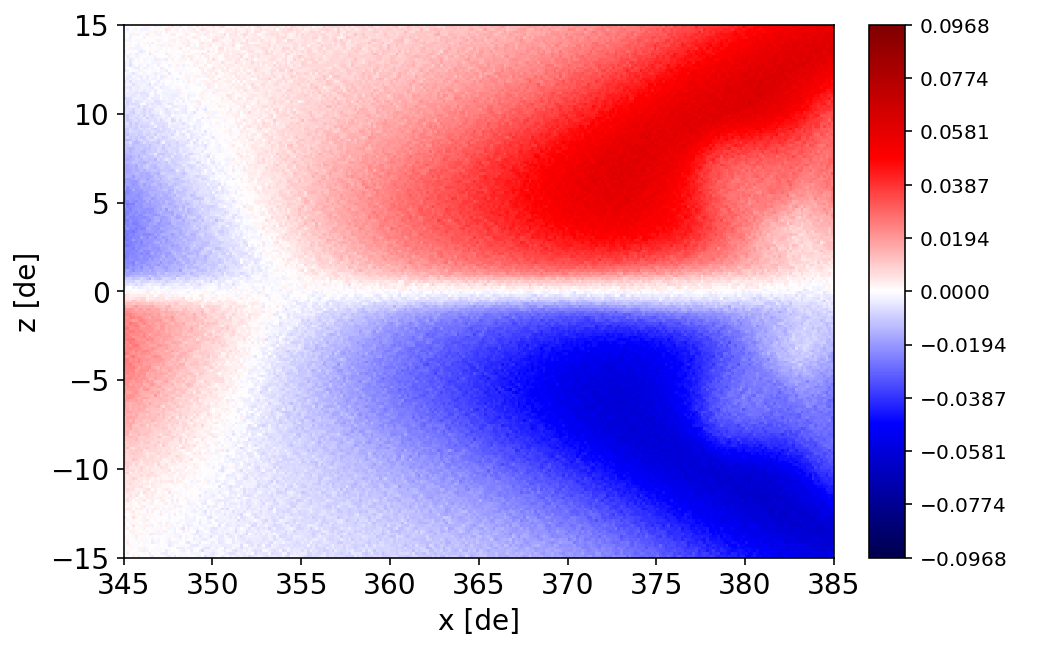

In [15]:
#Example Plot: Hall Magnetic fields
plt.figure(figsize=(7,7))
vlt.plot(B['y'],cmap = "seismic", symmetric=True, cbarlabel = " ", selection ="x=300f:500f, z=-100f:100f ")

plt.ylim(-15,15)
plt.xlim(345,385)

fnt=14
plt.xlabel("x [de]", fontsize=fnt)
plt.ylabel("z [de]", fontsize=fnt)
plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)


/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:523: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  p.get_cmap().set_bad(masknan)
/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:527: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  p.get_cmap().set_bad('y')


(array([-100.,  -75.,  -50.,  -25.,    0.,   25.,   50.,   75.,  100.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

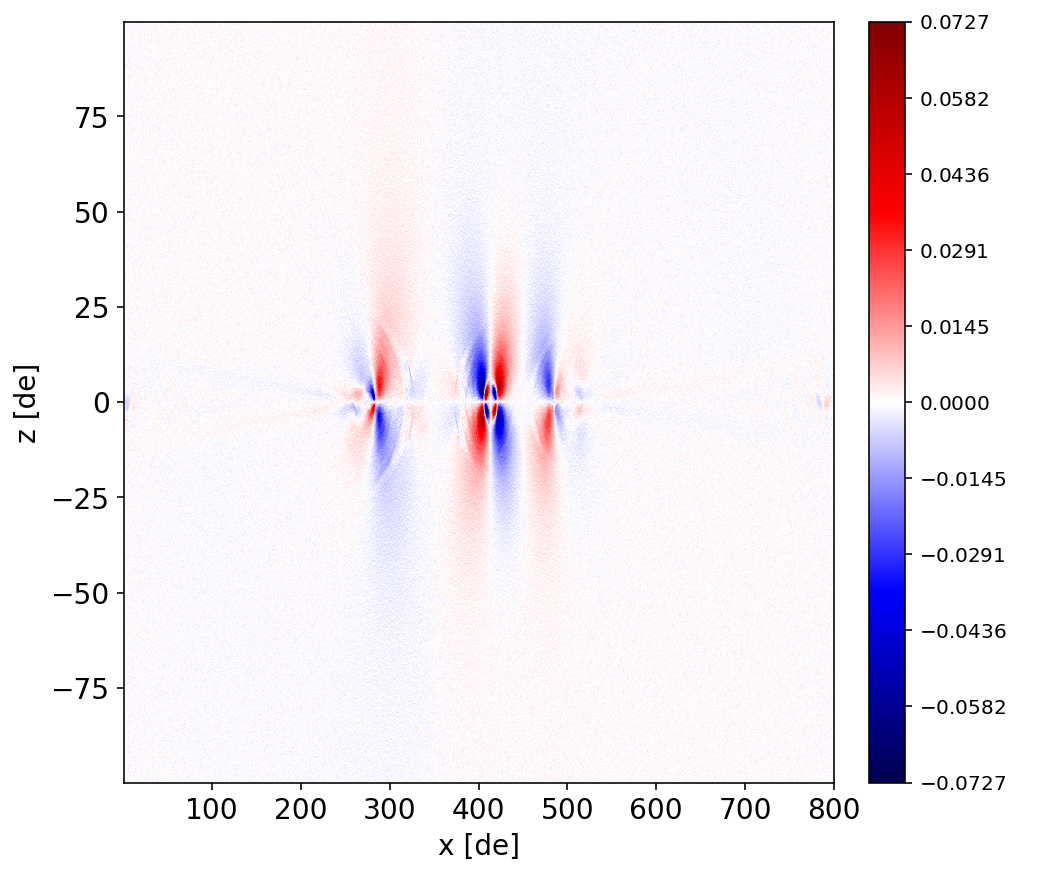

In [6]:
#Example Plot: Magnetic field gradient (try x and z)
plt.figure(figsize=(7,7))
vlt.plot(GradB['z'],cmap = "seismic", symmetric=True, cbarlabel = " ")

#plt.ylim(-15,15)
#plt.xlim(345,385)

fnt=14
plt.xlabel("x [de]", fontsize=fnt)
plt.ylabel("z [de]", fontsize=fnt)
plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)


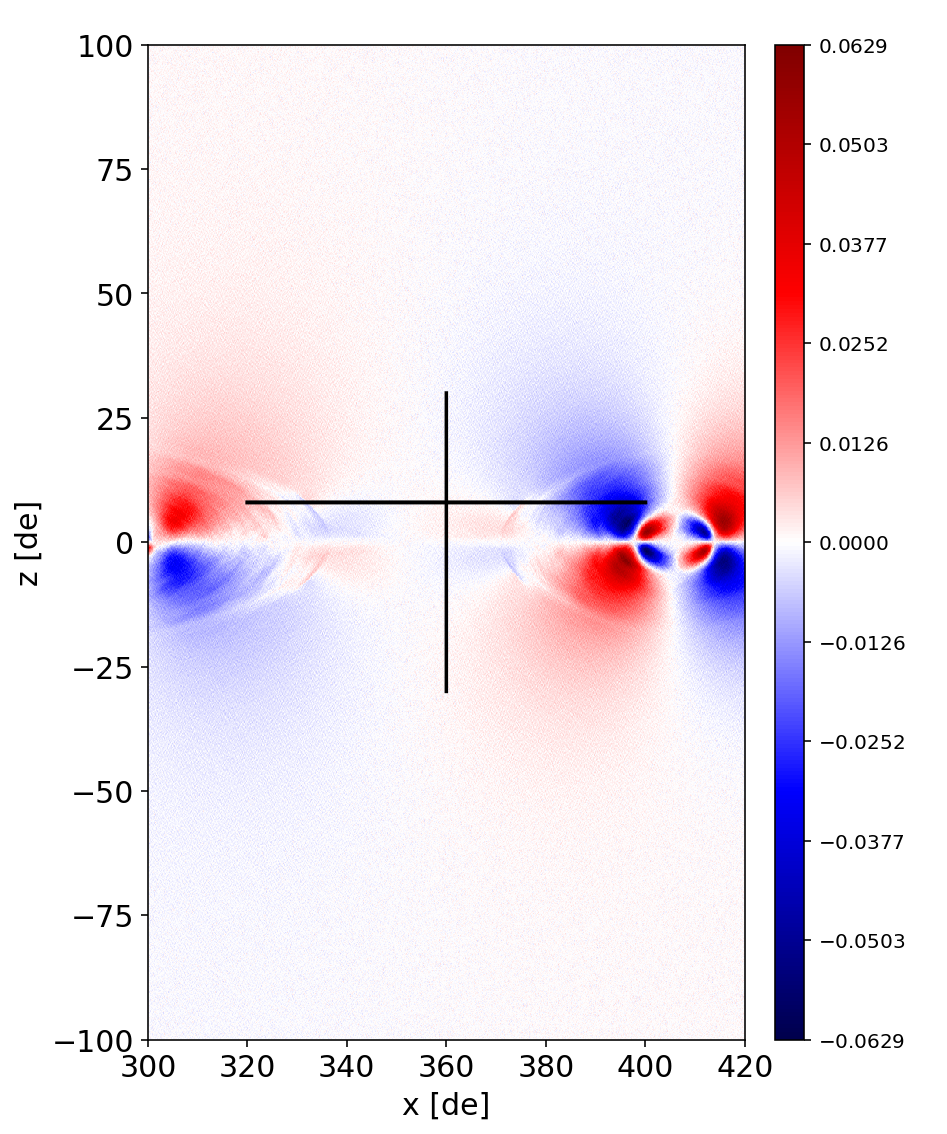

In [11]:
# Make 1D cuts to look at data along cut
# This cell makes 2 lines: a horizontal line from pt0 to pt1 and a vert line from pt2 to pt3
# all we're doing here is making the lines and associating their coordinates in the domain properly

# You could also make a diagonal cut between pt0 and pt1.  It doesn't have to be only vertical or horizontal

pt0 = (320, 0, 8) # x,y,z coords for beginning and end of a line in domain 
pt1 = (400, 0, 8)


pt2 = (360, 10, 30) # x,y,z coords for beginning and end of a line in domain (using pts#[t] keeps the vert line intersecting the center of x-point based on pre-defined pts)
pt3 = (360, 10, -30)
npts = 100000         # number of measurements along line between pt0 and pt1

# These are all important.  No time to explain.
lin_h = np.linspace(pt0[0], pt1[0], npts)
lin_v = np.linspace(pt2[2], pt3[2], npts)
seeds_h = viscid.seed.Line(pt0, pt1, npts)
seeds_v = viscid.seed.Line(pt2, pt3, npts)
seed_pts_v = seeds_v.get_points()
seed_pts_h = seeds_h.get_points()


fnt = 15 #axis fontsizes


# Make colorplot
plt.figure(figsize=(8,8))
plt.subplot(1,1,1)
vlt.plot(GradB['z'],cmap = "seismic", symmetric = True, title = ' ', cbarlabel=" ") #Plotting dBz/dz in this case
plt.axis("image")
plt.xlim(300,420)
plt.ylim(-100,100)
plt.xlabel("x [de]", fontsize=fnt)
plt.ylabel("z [de]", fontsize=fnt)
plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)

# NOTE: The variable you put in the colorplot in this cell is just for viewing purposes.  In the next cell, you could choose a 
#        completely different variable and it would plot that variable along the cut.  I won't, but you could.  
# Example: sometimes I wanted to center the cuts on the non-ideal region, so I'd use Ey' in the colorplot to identify
#          where the cut should go, even if I was interested in plotting a bunch of different variables along that cut




# Make lines on top of colorplot
plt.plot(seed_pts_h[0,:], seed_pts_h[2,:], color = 'k', lw = 2) 
plt.plot(seed_pts_v[0,:], seed_pts_v[2,:], color = 'k')






vlt.tighten() #No idea what this does

(array([-40., -30., -20., -10.,   0.,  10.,  20.,  30.,  40.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

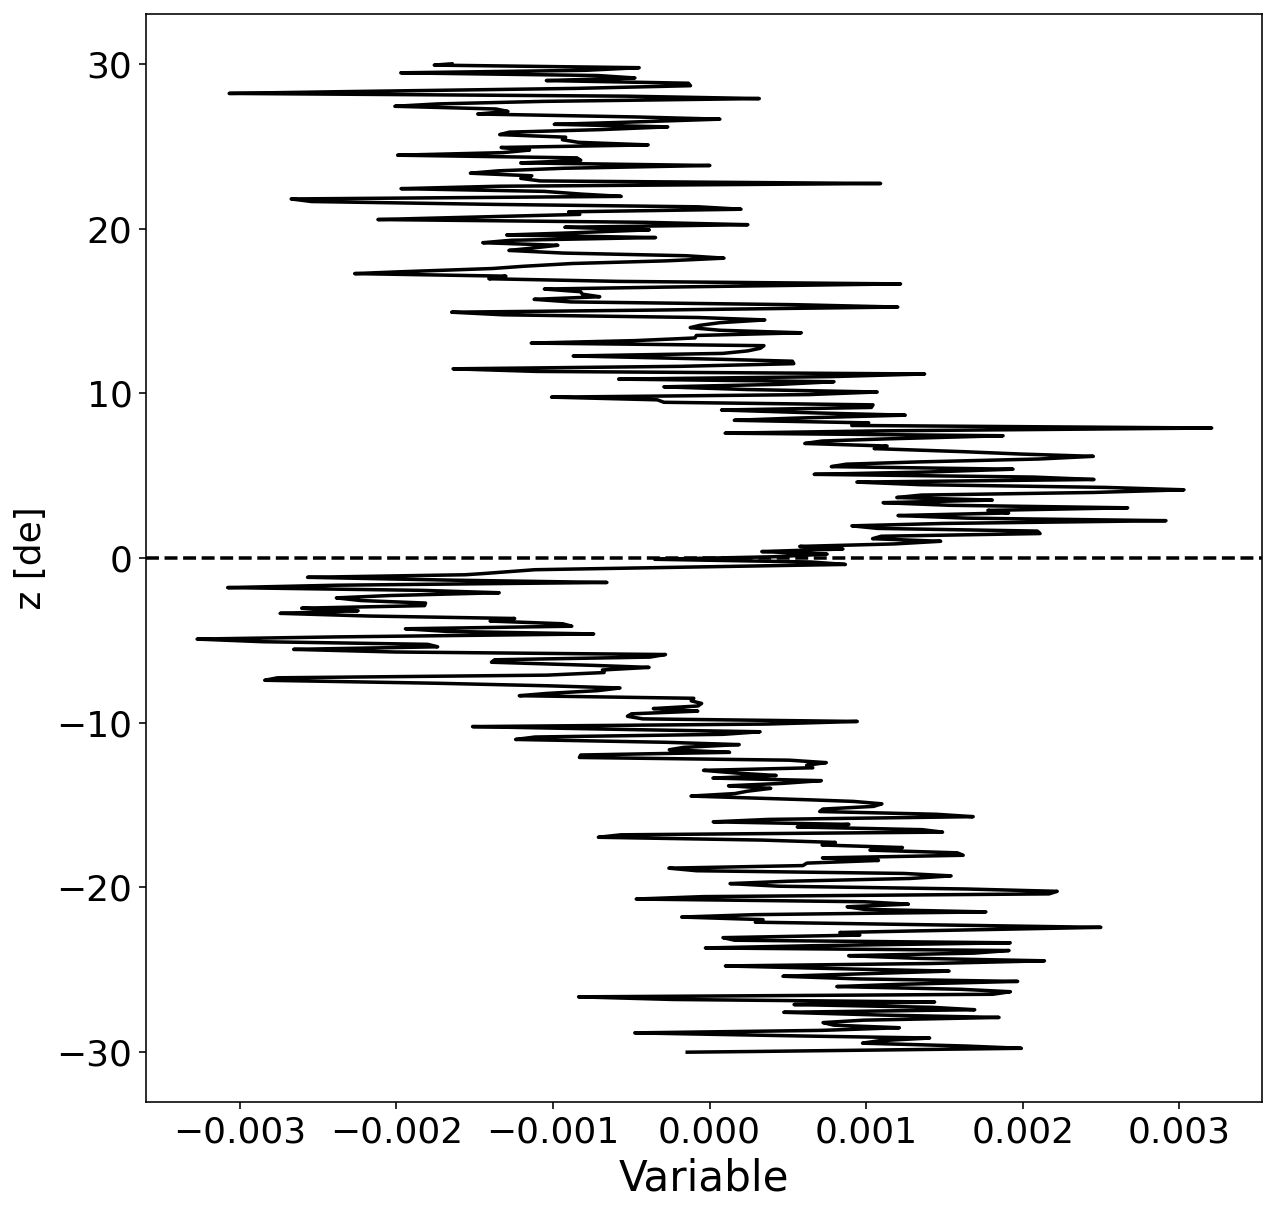

In [12]:
# Vertical Cut

plt.figure(figsize=(10,10))
plt.plot(viscid.interp_trilin(GradB['z'], seeds_v),lin_v , color = 'k')


plt.axhline(y = 0, color = 'k', linestyle = '--')#, label = 'upstream B0')



fnt = 18
plt.xlabel("Variable", fontsize = fnt+3)
plt.ylabel(" z [de] ",fontsize = fnt)

plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)



(array([-0.05, -0.04, -0.03, -0.02, -0.01,  0.  ,  0.01,  0.02]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

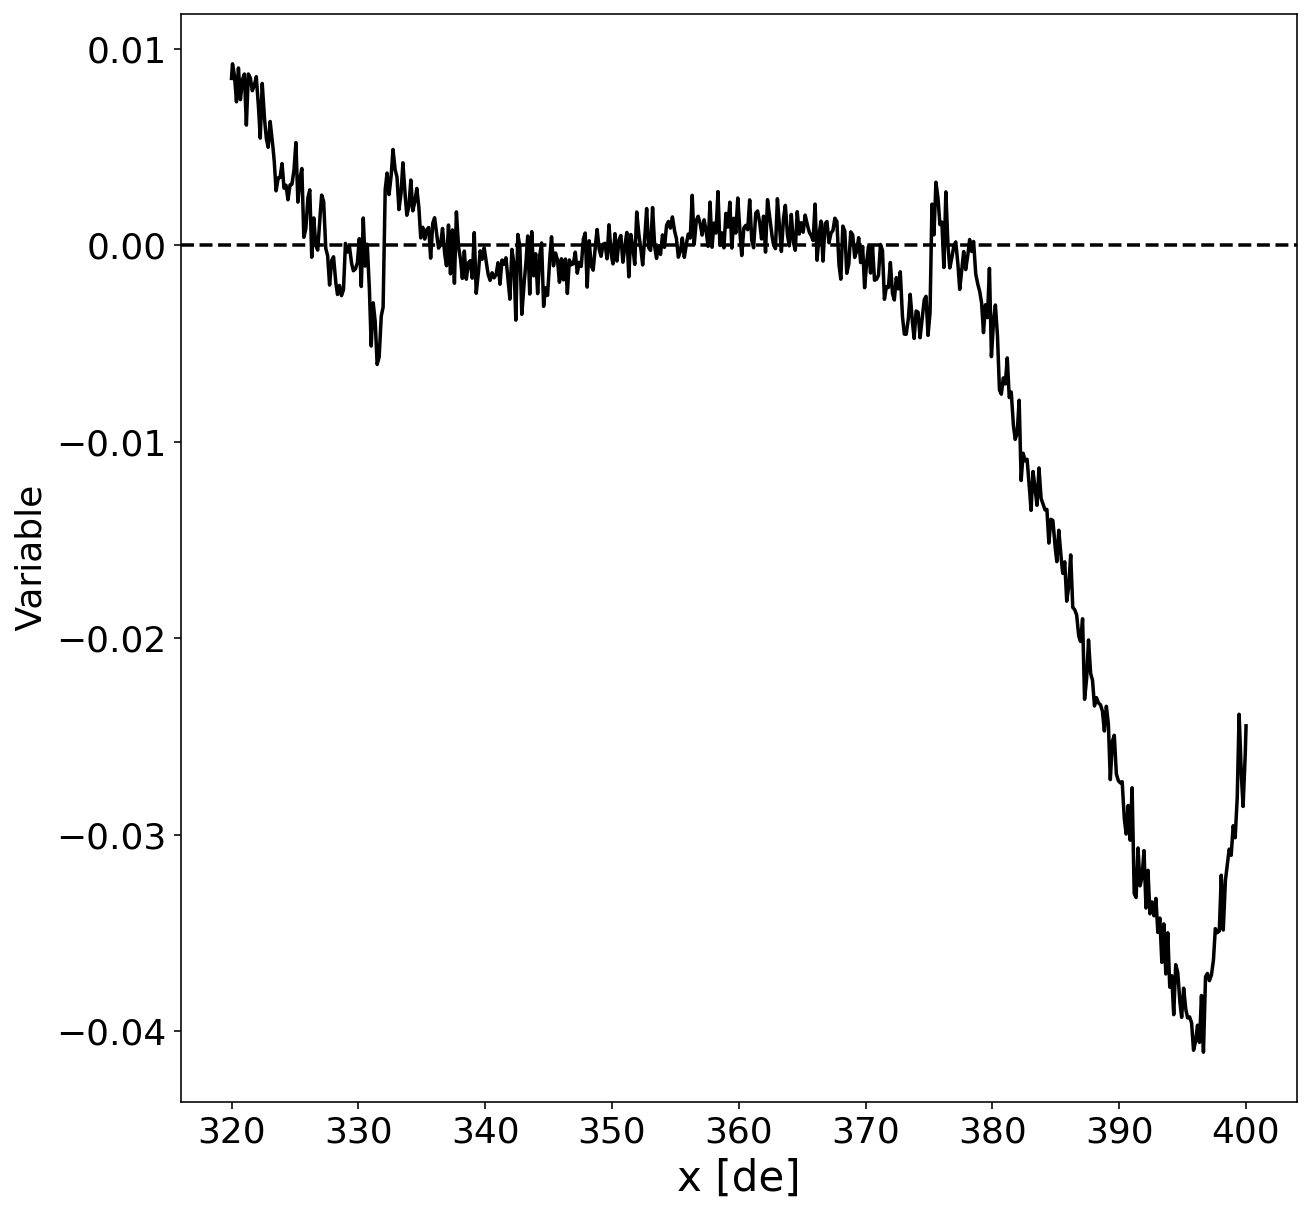

In [13]:
# Horizontal Cut

plt.figure(figsize=(10,10))
plt.plot(lin_h,viscid.interp_trilin(GradB['z'], seeds_h), color = 'k')


plt.axhline(y = 0, color = 'k', linestyle = '--')#, label = 'upstream B0')



fnt = 18
plt.xlabel("x [de]", fontsize = fnt+3)
plt.ylabel(" Variable ",fontsize = fnt)

plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)

